In [2]:
import sys
import pickle
import numpy as np
import tensorflow as tf
import PIL.Image
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.signal as sig

### 1. Fetch dataset

In [3]:
new_path = r'/home/users/suihong/4-progressive_growing_of_gans_TF_Probimg_AverageLoss/'
sys.path.append(new_path)

# Initialize TensorFlow session.
tf.InteractiveSession()

import dataset
data_dir_test = '/scratch/users/suihong/DataSets(MultiChannels_V4_Consistency_HighestFrequcyDownSampling)/'
test_set = dataset.load_dataset(data_dir=data_dir_test, verbose=True, tfrecord_dir='TestData', max_label_size = 'full', shuffle_mb = 0, prefetch_mb = 0)

# Following are correspondent, but not ordered with respect to labels
image_test, label_test = test_set.get_minibatch_imageandlabel_np(3000)  # labels include [orientation, mud ratio, width, sinuosity], from -1 to 1
probimg_test, wellfacies_test = test_set.get_minibatch_probandwell_np(3000*8)


Streaming data using dataset.TFRecordDataset...
Dataset shape = [1, 64, 64]
Dynamic range = [0, 255]
Label size    = 4


In [4]:
print(image_test.shape)
print(label_test.shape)
print(probimg_test.shape)
print(wellfacies_test.shape)

(3000, 1, 64, 64)
(3000, 4)
(24000, 1, 64, 64)
(24000, 1, 64, 64)


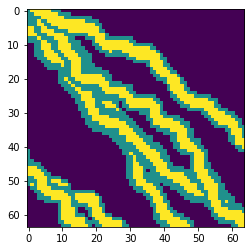

In [5]:
plt.imshow(image_test[55,0])

To recover the global features with its original scales, use the below transformation functions.

Parameters in these functions are obtained from statistics of all datasets including training and test datasets:

orientation: min = -84, max = 84, max - min = 168

back_ratio: min = 0.167724609375, max - min = 0.8037109375

width:...

amplitude to wavelength ratio:...


In [6]:
orit_test = (label_test[:,0]/2+0.5)*168-84
back_ratio_test = (label_test[:,1]/2+0.5)*0.8037109375+0.167724609375
width_test = (label_test[:,2]/2+0.5)*0.8+2.7
amwv_ratio_test = (label_test[:,3]/2+0.5)*0.4866197183098592+0.06338028169014084

### 2. Import pre-trained Network

In [7]:
# Initialize TensorFlow session.
tf.InteractiveSession()

# Import networks.
network_dir = '/scratch/users/suihong/ProGAN_MultiChannel_Reusults_ConditionedtoMultiConditions_TF/1031-pgan-CondProb-w0.1-new-FS-2gpu/'
with open(network_dir + 'network-snapshot-012160.pkl', 'rb') as file:
    G, D, Gs = pickle.load(file)

/share/software/user/open/py-tensorflow/1.12.0_py36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


### 3. Evaluation of the imported pretrained Generator


#### 3.1 Fetch 300 inputs from Test dataset

In [8]:
# Sample 300 global features, probability maps, and well facies data
faciesmodels_real = image_test[:3000]
labels_inspect = label_test[:3000]
proborder = np.arange(3000) * 8 + np.random.RandomState(32).randint(0, 8, size=3000)
probimg_inspect = np.float32(probimg_test[proborder])

wellfacies_inspect_init = wellfacies_test[proborder]
wellfacies_points_inspect = np.where(wellfacies_inspect_init>0, 1, 0)
wellfacies_facies_inspect = np.where(wellfacies_inspect_init<1.5, 0, 1)
wellfacies_inspect = np.concatenate([wellfacies_points_inspect, wellfacies_facies_inspect], 1)

In [9]:
print(labels_inspect.shape)
print(probimg_inspect.shape)
print(wellfacies_inspect.shape)

(3000, 4)
(3000, 1, 64, 64)
(3000, 2, 64, 64)


#### 3.2 Some simulations for visualizations

In [10]:
print(Gs.input_shapes)

[[None, 128], [None, 4], [None, 1, 64, 64]]


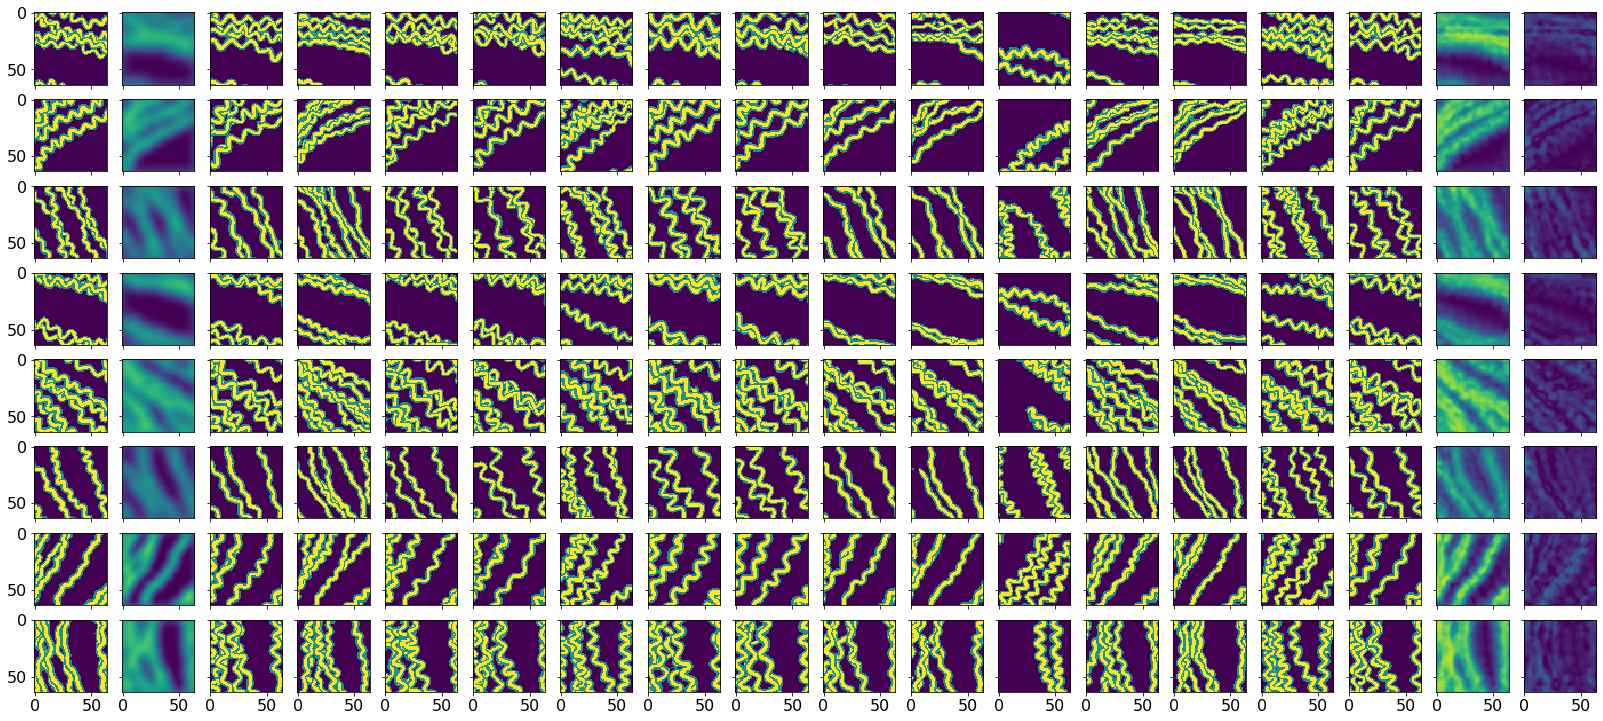

In [20]:
fig, ax = plt.subplots(8, 18, sharex='col', sharey='row')
fig.set_size_inches(28, 12.5, forward=True)
plt.rcParams.update({'font.size': 16})

generate_facies_probs = np.zeros((8,1,64,64), dtype=np.float32)

images_plt_average = np.zeros((8,1,64,64))
for i in range (8):

    ax[i, 0].imshow(faciesmodels_real[i,0,:,:]) 
    ax[i, 1].imshow(probimg_inspect[i,0,:,:],vmin = 0.0, vmax = 1) 
    
    latents_plt = np.random.RandomState(12).randn(3000, Gs.input_shapes[0][1])  #   RandomState
    labels_plt = np.random.randn(3000, Gs.input_shapes[1][1])
    probimg_plt = np.repeat(np.expand_dims(probimg_inspect[i], axis=0), 3000, axis=0)
    
    images_plt = Gs.run(latents_plt, labels_plt, probimg_plt)
    images_plt = np.where(images_plt< -0.3, -1, images_plt)
    images_plt = np.where(images_plt> 0.3, 1, images_plt)
    images_plt = np.where((images_plt>= -0.3) & (images_plt<= 0.3), 0, images_plt)
    for j in range(2,16):
        ax[i, j].imshow(images_plt[j-2,0,:,:])
    
    images_plt_a = np.where(images_plt> -0.3, 1, 0)  
    images_plt_average[i] = np.average(images_plt_a, axis = 0)    
    ax[i, 16].imshow(images_plt_average[i,0,:,:],vmin = 0.0, vmax = 1)
    ax[i, 17].imshow(np.absolute(probimg_inspect[i,0] - images_plt_average[i, 0]),vmin = 0.0, vmax = 1)

plt.savefig(network_dir + "Random Facies model samples.png", dpi=200) 

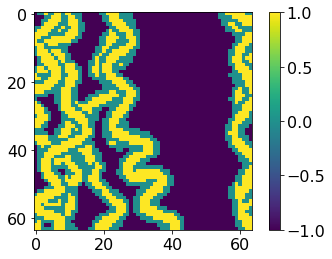

In [13]:
plt.imshow(images_plt[3,0,:,:])
plt.colorbar()

##### Latent vector changing from -random latent vector to + random latent vector

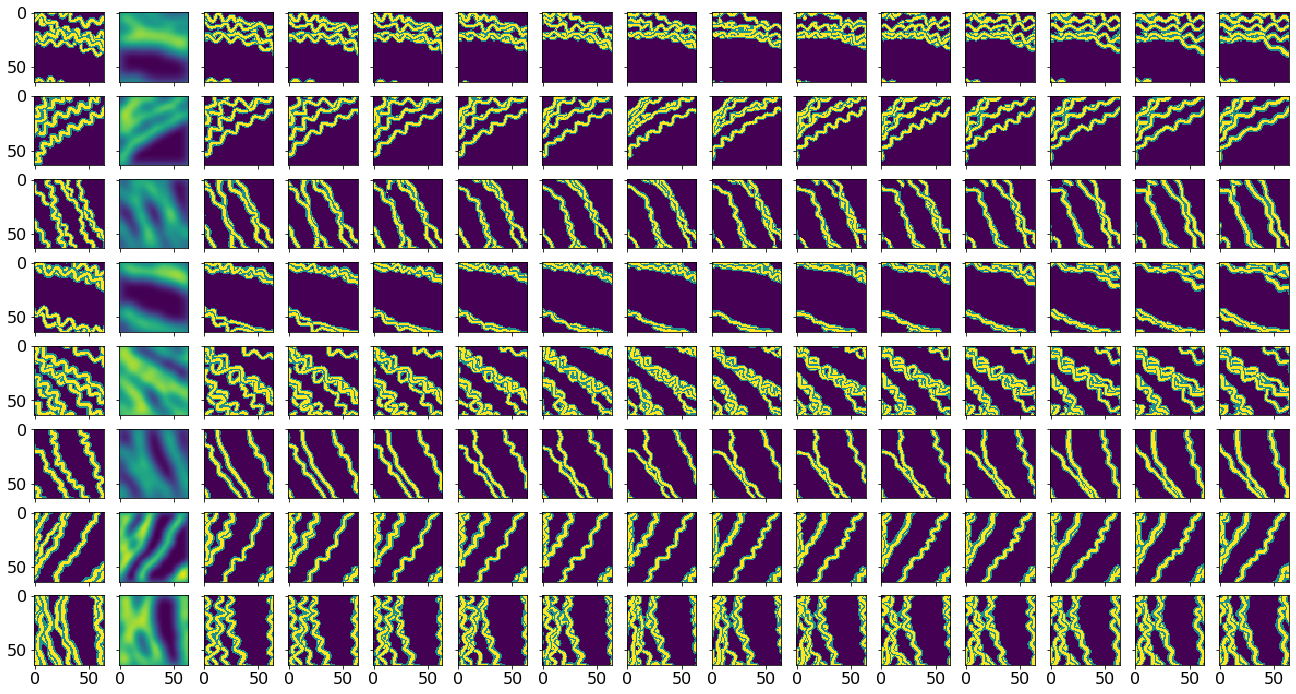

In [21]:
fig, ax = plt.subplots(8, 15, sharex='col', sharey='row')
fig.set_size_inches(22.5, 12, forward=True)

generate_facies_probs = np.zeros((18,1,64,64), dtype=np.float32)

images_plt_average = np.zeros((8,1,64,64))

latents_plt = np.zeros((1 * 13, Gs.input_shapes[0][1]))

a = np.random.randn(1, Gs.input_shapes[0][1])
b = -a 

for k in range(13):
    latents_plt[k] = a + (b - a) /12 * k


for i in range (8):

    ax[i, 0].imshow(faciesmodels_real[i,0,:,:]) 
    ax[i, 1].imshow(probimg_inspect[i,0,:,:],vmin = 0.0, vmax = 0.8) 
    
    
    labels_plt = np.random.randn(1 * 13, Gs.input_shapes[1][1])
    probimg_plt = np.repeat(np.expand_dims(probimg_inspect[i], axis=0), 1 * 13, axis=0)
    
    images_plt = Gs.run(latents_plt, labels_plt, probimg_plt)
    images_plt = np.where(images_plt< -0.3, -1, images_plt)
    images_plt = np.where(images_plt> 0.3, 1, images_plt)
    images_plt = np.where((images_plt>= -0.3) & (images_plt<= 0.3), 0, images_plt)
    for j in range(2,15):
        ax[i, j].imshow(images_plt[j-2,0,:,:])
    
plt.savefig(network_dir + "Facies models with gradual change input latents.png", dpi=200) 

#### 3.3 Generated facies models with gradual changing input latent vectors  (with gradual deformation)

In [16]:
v1 = np.random.RandomState(3).randn(1, Gs.input_shapes[0][1])
v2 = np.random.RandomState(485).randn(1, Gs.input_shapes[0][1])
v3 = np.random.RandomState(54).randn(1, Gs.input_shapes[0][1])

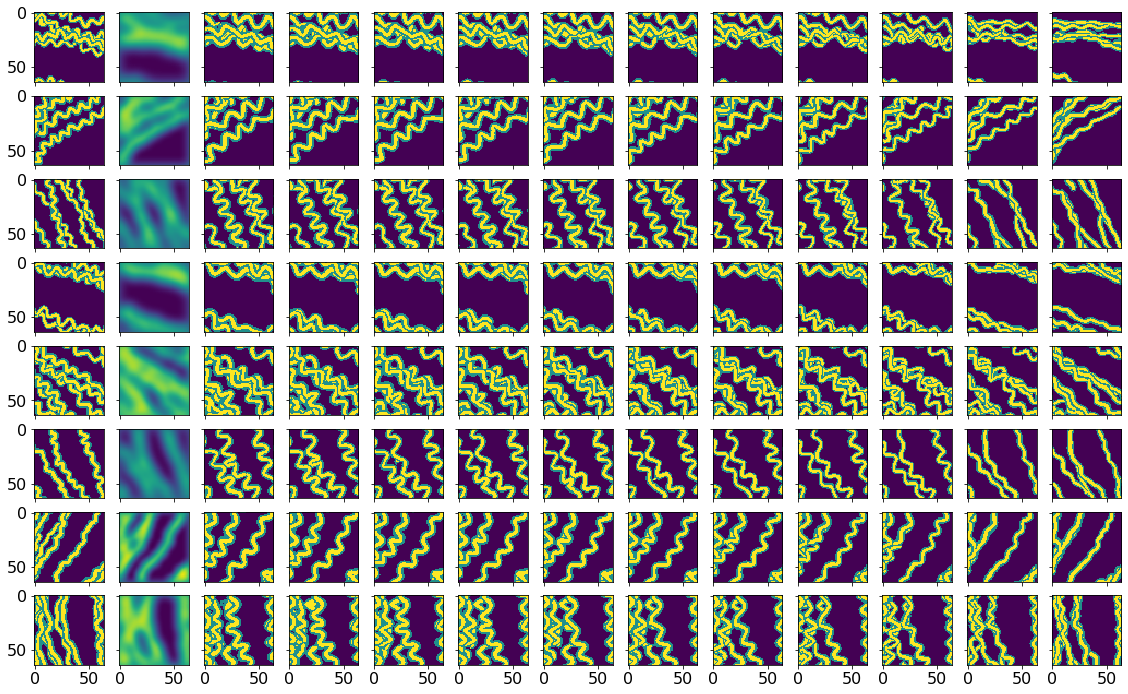

In [17]:
# Gradual Deformation v1-v2

fig, ax = plt.subplots(8, 13, sharex='col', sharey='row')
fig.set_size_inches(19.5, 12, forward=True)

generate_facies_probs = np.zeros((13,1,64,64), dtype=np.float32)

images_plt_average = np.zeros((8,1,64,64))

latents_plt = np.zeros((1 * 11, Gs.input_shapes[0][1]))

for k in range(11):
    sinta = np.pi/2*k/10
    latents_plt[k] = v1*np.cos(sinta) + v2*np.sin(sinta)
    
for i in range (8):

    ax[i, 0].imshow(faciesmodels_real[i,0,:,:]) 
    ax[i, 1].imshow(probimg_inspect[i,0,:,:],vmin = 0.0, vmax = 0.8) 
    
    
    labels_plt = np.random.randn(1 * 11, Gs.input_shapes[1][1])
    probimg_plt = np.repeat(np.expand_dims(probimg_inspect[i], axis=0), 1 * 11, axis=0)
    
    images_plt = Gs.run(latents_plt, labels_plt, probimg_plt)
    images_plt = np.where(images_plt< -0.3, -1, images_plt)
    images_plt = np.where(images_plt> 0.3, 1, images_plt)
    images_plt = np.where((images_plt>= -0.3) & (images_plt<= 0.3), 0, images_plt)
    for j in range(2,13):
        ax[i, j].imshow(images_plt[j-2,0,:,:])

plt.savefig(network_dir + "Facies models with gradual change input latents_GD_v1v2.png", dpi=200) 

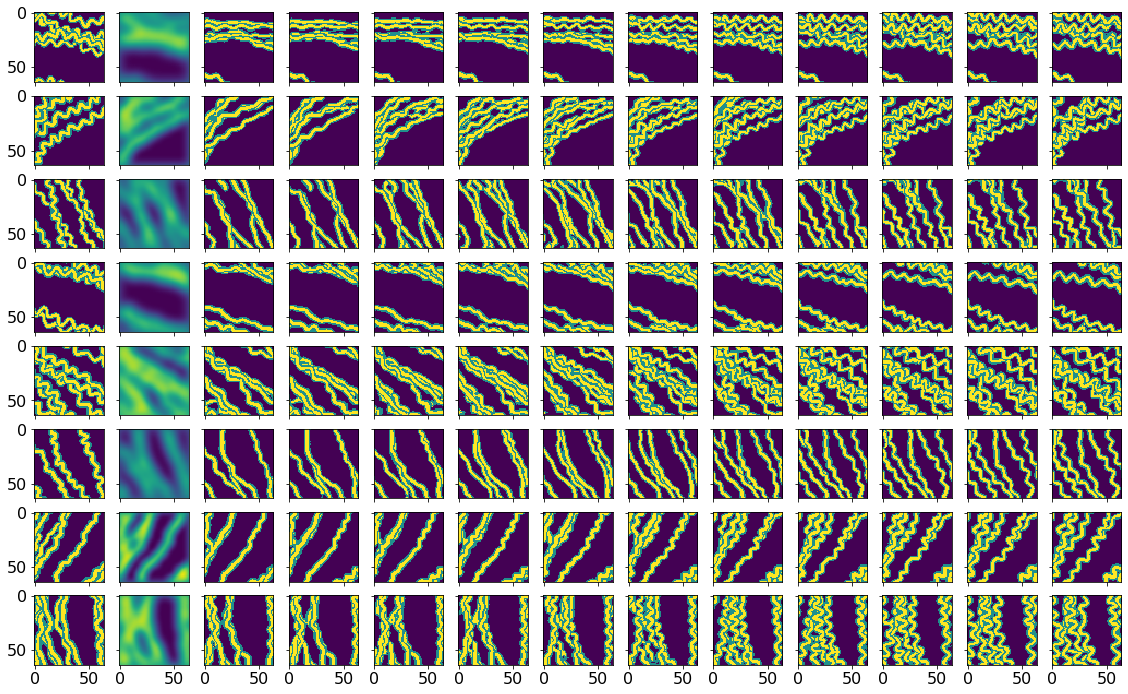

In [18]:
# Gradual Deformation v2-v3

fig, ax = plt.subplots(8, 13, sharex='col', sharey='row')
fig.set_size_inches(19.5, 12, forward=True)

generate_facies_probs = np.zeros((13,1,64,64), dtype=np.float32)

images_plt_average = np.zeros((8,1,64,64))

latents_plt = np.zeros((1 * 11, Gs.input_shapes[0][1]))



for k in range(11):
    sinta = np.pi/2*k/10
    latents_plt[k] = v2*np.cos(sinta) + v3*np.sin(sinta)
    
for i in range (8):

    ax[i, 0].imshow(faciesmodels_real[i,0,:,:]) 
    ax[i, 1].imshow(probimg_inspect[i,0,:,:],vmin = 0.0, vmax = 0.8) 
    
    
    labels_plt = np.random.randn(1 * 11, Gs.input_shapes[1][1])
    probimg_plt = np.repeat(np.expand_dims(probimg_inspect[i], axis=0), 1 * 11, axis=0)
    
    images_plt = Gs.run(latents_plt, labels_plt, probimg_plt)
    images_plt = np.where(images_plt< -0.3, -1, images_plt)
    images_plt = np.where(images_plt> 0.3, 1, images_plt)
    images_plt = np.where((images_plt>= -0.3) & (images_plt<= 0.3), 0, images_plt)
    for j in range(2,13):
        ax[i, j].imshow(images_plt[j-2,0,:,:])

plt.savefig(network_dir + "Facies models with gradual change input latents_GD_v2v3.png", dpi=200) 

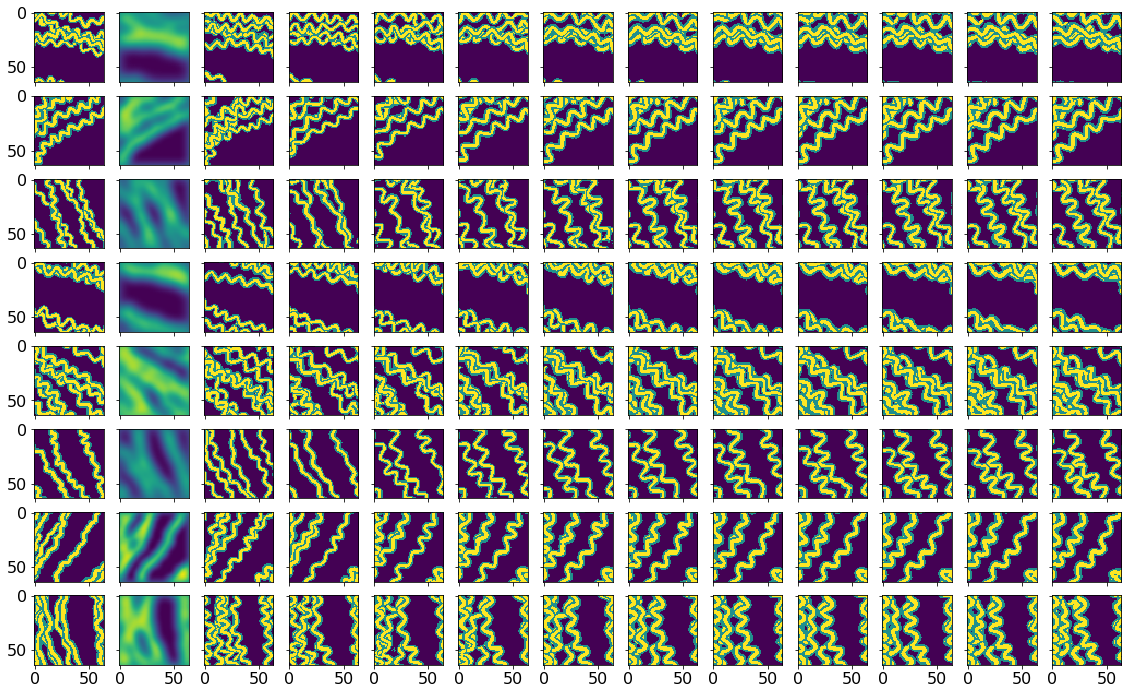

In [19]:
# Gradual Deformation v3-v1

fig, ax = plt.subplots(8, 13, sharex='col', sharey='row')
fig.set_size_inches(19.5, 12, forward=True)

generate_facies_probs = np.zeros((13,1,64,64), dtype=np.float32)

images_plt_average = np.zeros((8,1,64,64))

latents_plt = np.zeros((1 * 11, Gs.input_shapes[0][1]))

for k in range(11):
    sinta = np.pi/2*k/10
    latents_plt[k] = v3*np.cos(sinta) + v1*np.sin(sinta)
    
for i in range (8):

    ax[i, 0].imshow(faciesmodels_real[i,0,:,:]) 
    ax[i, 1].imshow(probimg_inspect[i,0,:,:],vmin = 0.0, vmax = 0.8) 
    
    
    labels_plt = np.random.randn(1 * 11, Gs.input_shapes[1][1])
    probimg_plt = np.repeat(np.expand_dims(probimg_inspect[i], axis=0), 1 * 11, axis=0)
    
    images_plt = Gs.run(latents_plt, labels_plt, probimg_plt)
    images_plt = np.where(images_plt< -0.3, -1, images_plt)
    images_plt = np.where(images_plt> 0.3, 1, images_plt)
    images_plt = np.where((images_plt>= -0.3) & (images_plt<= 0.3), 0, images_plt)
    for j in range(2,13):
        ax[i, j].imshow(images_plt[j-2,0,:,:])

plt.savefig(network_dir + "Facies models with gradual change input latents_GD_v3v1.png", dpi=200) 



### 4. Quantitative evaluation of the imported pretrained Network



#### 4.1 Evaluation of conditioning ability to probability maps

In [22]:
images_plt_average = np.zeros((100,1,64,64))
for i in range (100):   
    latents_plt = np.random.randn(1 * 500, Gs.input_shapes[0][1])
    labels_plt = np.random.randn(1 * 500, Gs.input_shapes[1][1])
    probimg_plt = np.repeat(np.expand_dims(probimg_inspect[i], axis=0), 1 * 500, axis=0)
    
    images_plt = Gs.run(latents_plt, labels_plt, probimg_plt)
    
    images_plt = np.where(images_plt< -0.3, -1, images_plt)
    images_plt = np.where(images_plt> 0.3, 1, images_plt)
    images_plt = np.where((images_plt>= -0.3) & (images_plt<= 0.3), 0, images_plt)
    
    images_plt = np.where(images_plt> -0.3, 1, 0)      
    images_plt_average[i] = np.average(images_plt, axis = 0)

y=1.237983x+(0.016854)
y=1.195162x+(0.018663)
y=1.143930x+(0.059956)
y=1.052374x+(0.061453)
y=1.177081x+(0.022614)
y=1.039548x+(0.083520)
y=1.193940x+(0.055240)
y=1.126211x+(0.048867)
y=1.105259x+(0.071189)
y=1.110801x+(0.060098)
y=1.046652x+(0.102779)
y=1.352221x+(0.042158)
y=1.275019x+(-0.016163)
y=1.150805x+(0.035177)
y=1.190192x+(0.077527)
y=1.309636x+(0.038956)
y=1.309455x+(-0.002430)
y=1.199778x+(0.017820)
y=1.167634x+(0.057428)
y=1.103698x+(0.063866)
y=1.261718x+(0.008539)
y=1.047426x+(0.066980)
y=1.184237x+(0.065730)
y=1.087420x+(0.031972)
y=1.011129x+(0.102568)
y=1.065014x+(0.031063)
y=1.131763x+(0.024766)
y=1.244204x+(0.014981)
y=1.163468x+(0.024169)
y=1.197648x+(0.024226)
y=1.101805x+(0.048252)
y=1.148709x+(0.032960)


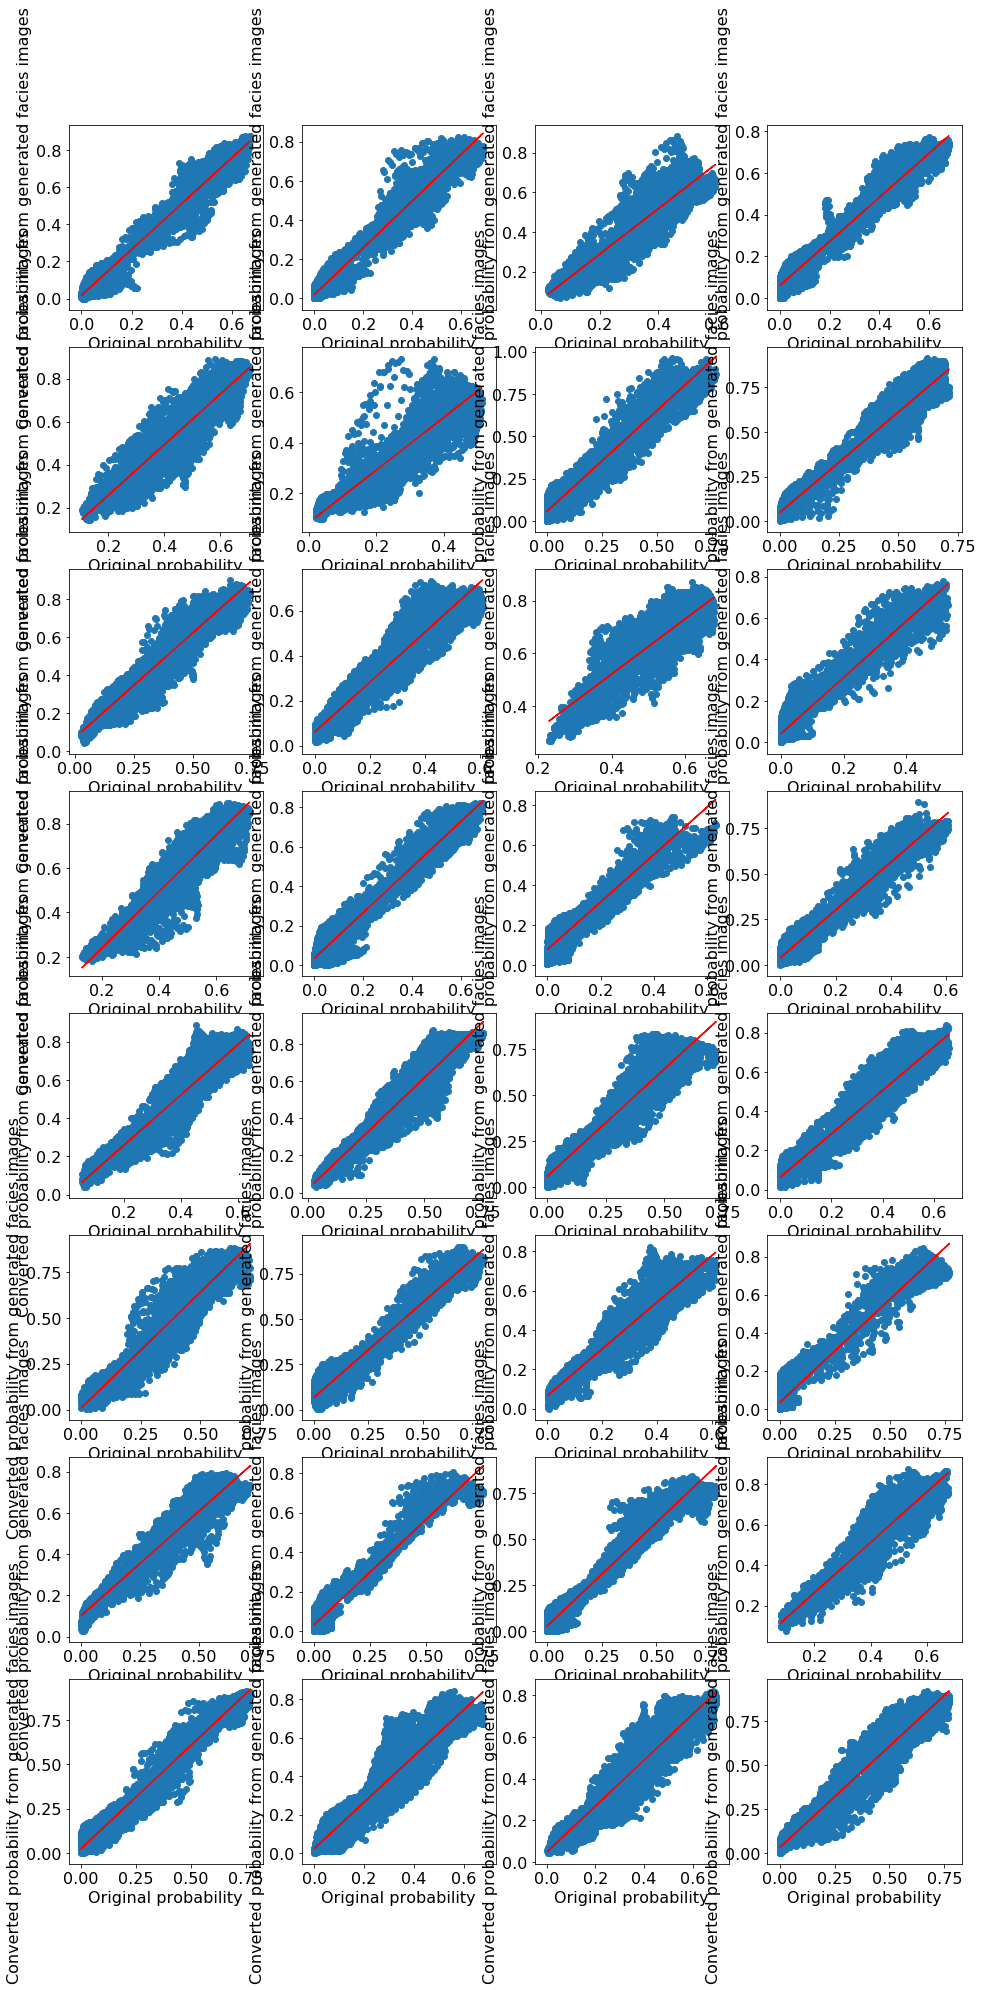

In [23]:
display_probs_2d = probimg_inspect[:100].reshape((100,-1))
generate_facies_probs_2d = images_plt_average.reshape((100,-1))

fig, ax = plt.subplots(8, 4)
fig.set_size_inches(16, 32, forward=True)

for i in range(8):
    for j in range(4):
        ax[i, j].scatter(display_probs_2d[i*4+j, :], generate_facies_probs_2d[i*4+j, :]) 
        # calc the trendline
        z1 = np.polyfit(display_probs_2d[i*4+j, :], generate_facies_probs_2d[i*4+j, :], 1)
        p1 = np.poly1d(z1)
        ax[i,j].plot(display_probs_2d[i*4+j, :],p1(display_probs_2d[i*4+j, :]),"r-")
        # the line equation:
        print ("y=%.6fx+(%.6f)"%(z1[0],z1[1]))
        ax[i,j].set_xlabel("Original probability")
        ax[i,j].set_ylabel("Converted probability from generated facies images")

y=1.139197x+(0.048759)
R_square=0.93


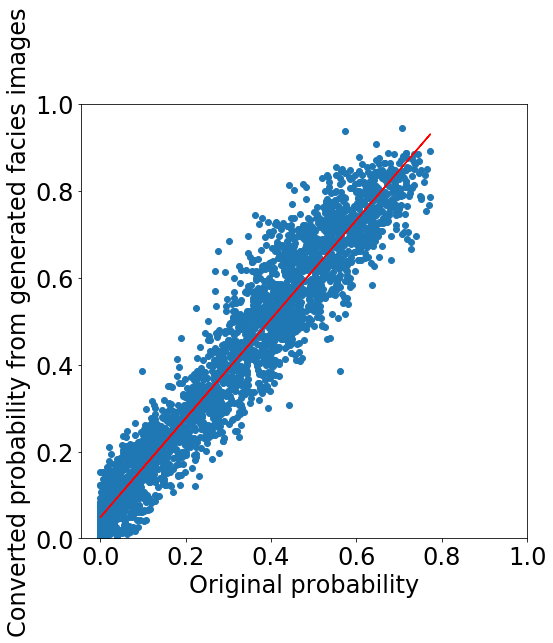

In [24]:
plt.rcParams.update({'font.size': 24})

display_probs_1d = probimg_inspect[:100].reshape((-1))
generate_facies_probs_1d = images_plt_average.reshape((-1))
random_sample = np.random.RandomState(3*i).randint(0, 356400, (3000))
display_probs_1d_smp = display_probs_1d[random_sample]
generate_facies_probs_1d_smp = generate_facies_probs_1d[random_sample]


fig, ax = plt.subplots(1, 1)
fig.set_size_inches(8, 8, forward=True)

ax.scatter(display_probs_1d_smp, generate_facies_probs_1d_smp) 
        # calc the trendline
z1 = np.polyfit(display_probs_1d_smp, generate_facies_probs_1d_smp, 1)
p1 = np.poly1d(z1)
ax.plot(display_probs_1d_smp,p1(display_probs_1d_smp),"r-")
ax.set_ylim(0, 1)

        # the line equation:
print ("y=%.6fx+(%.6f)"%(z1[0],z1[1]))

correlation = np.corrcoef(display_probs_1d_smp, generate_facies_probs_1d_smp)[0,1]
print("R_square=%.2f"%(correlation**2))

ax.set_xlabel("Original probability")
ax.set_ylabel("Converted probability from generated facies images")

plt.xticks(range(0, 1))
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.yticks(range(0, 1))
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

plt.savefig(network_dir + "crossplot between input and calculated prob.png", dpi=200) 

#### 4.2 MS-SWD-MDS evaluation of generated distribution

##### (1) Compare distribution of test facies models with that of generated facies models conditioned to various different probability maps

In [27]:
# Evaluate one or more metrics for a previous training run.
# To run, uncomment one of the appropriate lines in config.py and launch train.py.
def SWD_MDS_distribution_training_uncond(result_dir, Gs, random_test_faciesmodels, input_probmaps,num_images_per_group, num_groups_test, num_groups_fake):
    metric_objs = []    
    metric = 'SWD_MDS_distributions_training_uncond.API'
    metric_def = tfutil.import_obj(metric)
    image_shape = [3, 64, 64]
    obj = metric_def(image_shape=image_shape, image_dtype=np.uint8, num_images_per_group = num_images_per_group, num_groups_test = num_groups_test, num_groups_fake= num_groups_fake)
    tfutil.init_uninited_vars()
    metric_objs.append(obj)   
        
    mode ='fakes'
    [obj.begin(mode) for obj in metric_objs]  
    
    latents_swd = np.random.randn(num_groups_fake * num_images_per_group, Gs.input_shapes[0][1])
    labels_swd = np.random.randn(num_groups_fake * num_images_per_group, Gs.input_shapes[1][1])     
    images_swd = Gs.run(latents_swd, labels_swd, input_probmaps)        
    images_swd = np.where(images_swd< -0.3, -1, images_swd)
    images_swd = np.where(images_swd> 0.3, 1, images_swd)
    images_fake = np.where((images_swd>= -0.3) & (images_swd<= 0.3), 0, images_swd)
  
    images = np.concatenate((random_test_faciesmodels, images_fake), axis=0)
    
    if images.shape[1] == 1:
        images = np.tile(images, [1, 3, 1, 1]) # grayscale => RGB
    [obj.feed(mode, images, result_dir) for obj in metric_objs]


/home/users/suihong/4-progressive_growing_of_gans_TF_Probimg_AverageLoss/SWD_MDS_distributions_training_uncond.py:189: UserWarning: The following kwargs were not used by contour: 'label'
  real_contr = axes[1].contour(xi_real, yi_real, zi_real.reshape(xi_real.shape), 6, colors='r', label = 'Real')
/home/users/suihong/4-progressive_growing_of_gans_TF_Probimg_AverageLoss/SWD_MDS_distributions_training_uncond.py:194: UserWarning: The following kwargs were not used by contour: 'label'
  fake_contr_trad = axes[1].contour(xi_fake_trad, yi_fake_trad, zi_fake_trad.reshape(xi_fake_trad.shape), 5, colors='blue',  linestyles= 'dashed', label = 'Generated')


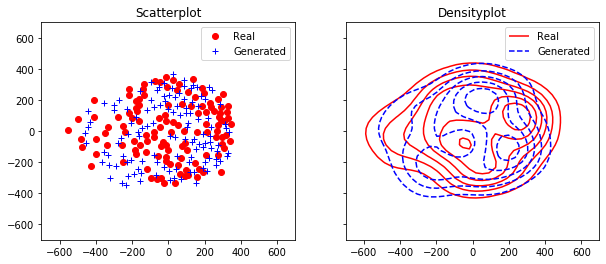

In [28]:
num_images_per_group=1
num_groups_test=120
num_groups_fake=120
random_test_faciesmodels = faciesmodels_real[:num_groups_test * num_images_per_group]/127.5-1
input_probmaps = np.float32(probimg_test[num_groups_fake* num_images_per_group*2:num_groups_fake* num_images_per_group*3])
plt.rcParams.update({'font.size': 10})
SWD_MDS_distribution_training_uncond(network_dir, Gs, random_test_faciesmodels, input_probmaps, num_images_per_group, num_groups_test, num_groups_fake)
plt.savefig(network_dir + 'SWD_MDS distribution_test_randprobmaps.jpg', dpi=200)  

##### (2) Compare the distribution of test facies models with that of generated facies models conditioned to a single probability map

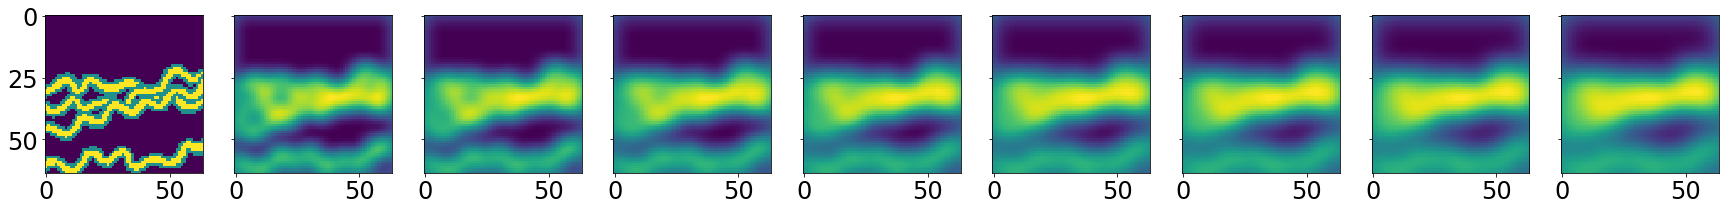

In [25]:
truth_order = 36

fig, ax = plt.subplots(1, 9, sharex='col', sharey='row')
fig.set_size_inches(30, 3, forward=True)

ax[0].imshow(faciesmodels_real[truth_order, 0])

for i in range (8):
    ax[i+1].imshow(np.float32(probimg_test[truth_order*8+i,0]))  
    
plt.savefig(network_dir + 'GroundTruthFM_and_Probmaps_truth_order_%i.jpg'%(truth_order), dpi=200)  

In [26]:
# Evaluate one or more metrics for a previous training run.
# To run, uncomment one of the appropriate lines in config.py and launch train.py.
import tfutil
def SWD_MDS_distribution_training_cond_truth(result_dir, Gs, random_test_faciesmodels, input_probmap, truth_faciesmodel, num_images_per_group, num_groups_test, num_groups_fake):
    metric_objs = []    
    metric = 'SWD_MDS_distributions_training_cond_truth.API'
    metric_def = tfutil.import_obj(metric)
    image_shape = [3, 64, 64]
    obj = metric_def(image_shape=image_shape, image_dtype=np.uint8, num_images_per_group = num_images_per_group, num_groups_test = num_groups_test, num_groups_fake= num_groups_fake)
    tfutil.init_uninited_vars()
    metric_objs.append(obj)   
        
    mode ='fakes'
    [obj.begin(mode) for obj in metric_objs]  
    
    latents_swd = np.random.randn(num_groups_fake * num_images_per_group, Gs.input_shapes[0][1])
    labels_swd = np.random.randn(num_groups_fake * num_images_per_group, Gs.input_shapes[1][1])
    probimg_swd = np.repeat(np.expand_dims(input_probmap, axis=0), num_groups_fake * num_images_per_group, axis=0)    
    images_swd = Gs.run(latents_swd, labels_swd, probimg_swd)      
    images_swd = np.where(images_swd< -0.3, -1, images_swd)
    images_swd = np.where(images_swd> 0.3, 1, images_swd)
    images_fake = np.where((images_swd>= -0.3) & (images_swd<= 0.3), 0, images_swd)
  
    truth_faciesmodels = np.repeat(truth_faciesmodel, num_images_per_group, axis=0)
    images = np.concatenate((random_test_faciesmodels, images_fake, truth_faciesmodels), axis=0)
    
    if images.shape[1] == 1:
        images = np.tile(images, [1, 3, 1, 1]) # grayscale => RGB
    [obj.feed(mode, images, result_dir) for obj in metric_objs]


/home/users/suihong/4-Upload_cond_Probmap/SWD_MDS_distributions_training_cond_truth.py:192: UserWarning: The following kwargs were not used by contour: 'label'
  real_contr = axes[1].contour(xi_real, yi_real, zi_real.reshape(xi_real.shape), 6, colors='r', label = 'Real')
/home/users/suihong/4-Upload_cond_Probmap/SWD_MDS_distributions_training_cond_truth.py:197: UserWarning: The following kwargs were not used by contour: 'label'
  fake_contr_trad = axes[1].contour(xi_fake_trad, yi_fake_trad, zi_fake_trad.reshape(xi_fake_trad.shape), 5, colors='blue',  linestyles= 'dashed', label = 'Generated')


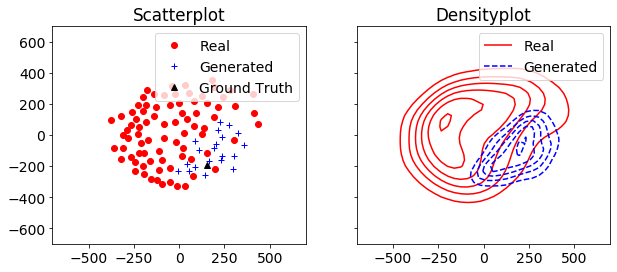

In [27]:
plt.rcParams.update({'font.size': 14})

truth_order = 36

num_images_per_group=1
num_groups_test=80
num_groups_fake=20
random_test_faciesmodels = faciesmodels_real[:num_groups_test * num_images_per_group]/127.5-1
truth_faciesmodel = faciesmodels_real[truth_order:truth_order+1]/127.5-1

for res_order in range(1):
    input_probmap = np.float32(probimg_test[truth_order*8+res_order])
    SWD_MDS_distribution_training_cond_truth(network_dir, Gs, random_test_faciesmodels, input_probmap, truth_faciesmodel, num_images_per_group, num_groups_test, num_groups_fake)
    plt.savefig(network_dir + 'SWD_MDS distribution_test_generated_groundtruth_truth_order_%i_res_order_%i.jpg'%(truth_order, res_order), dpi=200)  